In [1]:
from py_extrema.extrema import ExtremaFinder
from py_extrema.slopping_saddle import SloppingSaddle

from cycler import cycler
%pylab
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

/home/ccc/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Let us first generate a Gaussian random field in 2D with a power law power spectrum with slope $n_s = -1$.

In [2]:
mu = np.random.standard_normal((1024, 1024))
muk = np.fft.rfftn(mu)

kgrid = np.c_[np.meshgrid(*[np.fft.fftfreq(_) for _ in mu.shape[:-1]], np.fft.rfftfreq(mu.shape[-1]), indexing='ij')]
k = np.linalg.norm(kgrid, axis=0)
Pk = np.zeros_like(k)
Pk[k>0] = k[k>0]**-1

deltak = muk * np.sqrt(Pk)
delta = np.fft.irfftn(deltak)

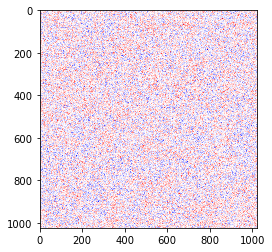

In [3]:
plt.imshow(delta, cmap='bwr')

# Extracting extrema from the field

Build the extrema finder.

In [4]:
ef = ExtremaFinder(delta, cache_len=1, nthreads=4, boxlen=100)

Using `ef.smooth`, we can easily get a smoothed version of the field. Note that the argument is in the same unit as `boxlen`, so that `ef.smooth(100)` will smooth with a Gaussian filter of the size of the box (that's a bad idea!).

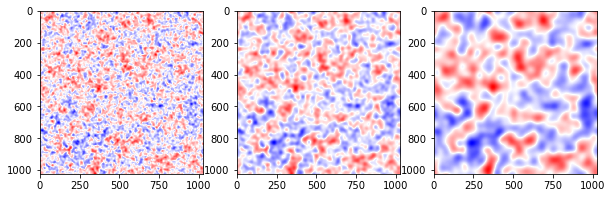

In [5]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=3)
for iR, R in enumerate((5, 10, 20)):
    axes[iR].imshow(ef.smooth(R), cmap='bwr')

Let's extract critical points now with a very large smoothing scale, so that we don't have many of them.

In [6]:
deltaR = ef.smooth(50)
extrema = ef.find_extrema(50).as_dataframe()  # get back a pandas dataframe

extrema.head()

,x,l1,h11,h12,y,l2,h22,kind,dens
0,40.477481,-0.000054,-0.000045,0.000012,16.302525,-0.000030,-0.000039,0,0.176095
1,45.901239,0.000014,0.000041,0.000026,861.503626,0.000065,0.000038,2,-0.120989
2,51.479171,-0.000019,0.000041,0.000028,395.253545,0.000054,-0.000006,1,-0.023935
3,52.299884,-0.000060,-0.000059,0.000002,666.943588,-0.000038,-0.000039,0,0.216895
4,67.654345,0.000016,0.000044,-0.000022,224.878193,0.000062,0.000034,2,-0.184289


The extrema are yielded back simply as a pandas dataframe.

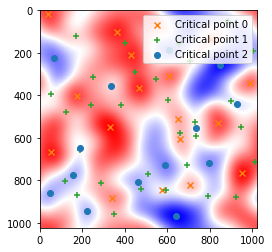

In [7]:
plt.imshow(deltaR.T, cmap='bwr')

cc = cycler(marker=['x', '+', 'o']) + cycler(color=['tab:orange', 'tab:green', 'tab:blue'])

for kind, style in zip(range(3), cc):
    ext = extrema[extrema.kind == kind]
    
    plt.scatter('x', 'y', data=ext, **style, label='Critical point %s' % kind)
plt.legend()

# Extracting critical events (critical point mergers)

Let's first build the extrema finder and the `slopping saddle` handler.

In [8]:
ef = ExtremaFinder(delta, cache_len=1, nthreads=4, boxlen=100)
ss = SloppingSaddle(ef, Rgrid=np.geomspace(1, 10, 10))

In [9]:
crit_events = ss.detect_extrema()

/home/ccc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/ccc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/ccc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
import ipyvolume as ipv

In [11]:
crit_events

,iR,kind,index,x,l1,h11,h12,y,l2,h22,dens,R,head
0,1,1,512,627.404108,1.734434e-05,0.000489,-0.000207,279.984679,0.000579,1.080772e-04,0.401446,13.225469,0.5
1,2,1,436,987.840006,4.592657e-06,0.000686,0.000005,88.677031,0.000686,4.635894e-06,-0.250771,17.081350,0.5
2,0,0,530,391.919979,-1.895013e-03,-0.000696,0.000833,85.846445,-0.000114,-1.313764e-03,0.572201,10.240000,0.5
3,0,0,482,357.383121,-1.119341e-03,-0.001074,-0.000211,353.068907,-0.000003,-4.806684e-05,-0.252802,10.240000,0.5
4,0,0,483,357.293768,-1.169236e-03,-0.001157,-0.000108,353.765254,0.000010,-2.420233e-06,-0.252766,10.240000,0.5
5,1,1,130,151.305314,3.098085e-05,0.000666,0.000548,392.180008,0.001140,5.051459e-04,0.409645,13.225469,0.5
6,0,0,972,701.336830,-1.659312e-03,-0.001595,-0.000311,558.891601,0.000005,-5.921674e-05,0.128867,10.240000,0.5
7,5,1,103,913.773515,-6.131288e-09,0.000020,0.000043,623.922735,0.000115,9.506143e-05,-0.075043,36.800652,0.5
8,0,1,1292,938.612270,4.571786e-05,0.001268,0.001635,862.476768,0.003457,2.234196e-03,-0.099712,10.240000,0.5
9,2,1,33,75.445001,1.706098e-05,0.000219,0.000142,823.119316,0.000318,1.167427e-04,-0.188487,17.081350,0.5


In [28]:
ipv.figure(width=600, height=600)
cc = cycler(color=['red', 'blue'])
for kind, style in zip(range(2), cc):
    ce = crit_events[crit_events.kind == kind]
    ipv.scatter(ce.x.values, ce.y.values, ce.R.values, **style)
ipv.zlabel('R')
ipv.show()